# Analysis of Emergency Maternal Care Deprivation in Kano and Lagos, Nigeria
> Note: This notebook requires the local environment dependencies listed in our [requirements.txt] (requirements.txt) file. Use this file to install the required packages in a virtual environment.

> To excecute OpenRouteService functions, it is required to install the [library dependencies](https://github.com/GIScience/openrouteservice-examples#local-installation). You should either have an [openrouteservice API key](https://openrouteservice.org/dev/#/signup) or a local ORS environment to complete the analysis.

The model concepts and processes are described in our documentation. The [Dataset-interpretability](https://github.com/urbanbigdatacentre/ideamaps-models/blob/a4084fb650424ac575941cdacb71421aa882bae4/models/emergency-maternal-care/kano/dataset-interpretability.md) file describes the rationale behind this model.

## Workflow:
The notebook is divided into the following sections:

1. Initial Setup
2. Data Preparation
3. Travel time estimates
4. Two-step floating catchment area (2SFCA) analysis
5. Results

## 1. Initial Setup

## Setting up the virtual environment

```bash
# Create a new virtual environment
# It is recommended to create this virtual environment in the scripts folder
python -m venv .venv

# Activate the virtual environment
source .venv/bin/activate
pip install -r requirements.txt
```

## To run your notebook in VS Code

```bash
pip install -U ipykernel
python -m ipykernel install --user --name=.venv
```

In [4]:
import os
from IPython.display import display
import requests

import folium
from folium.plugins import MarkerCluster
import openrouteservice
import time

import pandas as pd
import numpy as np
import fiona as fn
import geopandas as gpd
from shapely.geometry import shape, mapping
from shapely.geometry import Point
from shapely.geometry import box
from scipy.spatial import cKDTree
from tqdm import tqdm

import rasterio
from rasterio.transform import xy
from rasterio.mask import mask
import rasterstats as rs
import math

## Preprocessing
In this study, users first requested an ORS Matrix API key from the [OpenRouteService](https://openrouteservice.org/) platform and subsequently interacted with the OpenRouteService API through the instantiation of the OpenRouteService client. This is the OpenRouteService [API documentation](https://openrouteservice.org/dev/#/api-docs/introduction) for ORS Core-Version 9.0.0. 

Generate a [API Key](https://openrouteservice.org/dev/#/home?tab=1) (Token) it is necessary to sign up at the OpenRouteService dashboard by using your E-mail address or sign up with your GitHub. After logging in, go to the Dashboard by clicking on your profile icon and navigate to the API Keys section. Click "Create API Key" to generate a free key and then choose a service plan (the free plan has limited requests per day). Copy the API Key and store it securely. 

OpenRouteService primarily uses API keys for authentication. However, if a token is required for certain endpoints, you can send a request with your API key in the Authorization header. This process facilitated various geospatial analysis functions, including isochrone generation.


### Option 1: Using an ORS API Key
Make sure you have a .env file in the root directory with the following content:
```bash
    OPENROUTESERVICE_API_KEY='your_api_key'
```

In [42]:
# %%
# Read the api key from the .env file
from dotenv import load_dotenv
%load_ext dotenv
%dotenv
api_key = os.getenv('OPENROUTESERVICE_API_KEY')
client = openrouteservice.Client(key=api_key)

cannot find .env file


ValueError: No API key was specified. Please visit https://openrouteservice.org/sign-up to create one.

### Option 2: Using a local ORS service
Make sure you have set a local service that runs the OSM-based ORS API. 
```r
    # Insert R code from the local ORS service
```

For this study different kind of data were used. The dataset on healthcare facilities is sourced from a research ([Macharia, P.M. et al., 2023](https://doi.org/10.1038/s41597-023-02651-9)) which provides A geospatial database of close-to-reality travel times to obstetric emergency care in 15 Nigerian conurbations. The dataset were filtered by state name to isolate facilities in Kano and converted CSV file to shapefile based on coordinates using [QGIS](https://qgis.org/). 

The Level 2 administrative boundary data is sourced from [Humanitarian Data Exchange](https://data.humdata.org/) were used to correlate the isochrones and healthcare facility distribution with specific administrative regions. The data were filtered based on the administrative region name (lganame) to focus the analysis on Kano.

Despite being official, administrative boundaries may not reflect the actual patterns of human settlement or economic activity. Therefore, the team used the Functional Urban Area (FUA) as a complementary definition of the study areas. The FUA is defined by [the Joint Research Centre of the European Commission](https://commission.europa.eu/about/departments-and-executive-agencies/joint-research-centre_en) as the actual urban sprawl and human activities, encompassing the core city and economically or socially integrated surrounding regions. The FUA was obtained from [the Global Human Settlement Layer (GHSL) ](https://human-settlement.emergency.copernicus.eu/)dataset, which provides spatial data for functional urban areas worldwide. 

* [Datasets of health facilities](https://doi.org/10.6084/m9.figshare.22689667.v2) (15/07/2023)
* [Shapefile of district boundaries](https://data.humdata.org/dataset/nigeria-admin-level-2) - Admin Level 2 (data from Humanitarian Data Exchange, 25/11/2015)
* [Functional Urban Areas](https://human-settlement.emergency.copernicus.eu/download.php?ds=FUA) - data from Global Human Settlement Layer(2015)

### Option 1: Kano
If you want to process data for the city of Kano, use the following code to filter the dataset. 


In [1]:
# Set paths to access Kano data
# Define directories
data_inputs = '../scripts/Kano/data-inputs/'
data_temp = '../scripts/Kano/data-temp/'
model_outputs = '../kano/'

### Option 2: Lagos
If you want to process data for the city of Kano, use the following code to filter the dataset. 

In [2]:
# Set paths to access Lagos data
# Define directories
data_inputs = '../scripts/Lagos/data-inputs/'
data_temp = '../scripts/Lagos/data-temp/'
model_outputs = '../Lagos/'

## Data Collection

### 1. Validated healthcare facilities for Kano
note: to describe the process to validate healthcare facilities

In [3]:
healthcare_facilities_validated = gpd.read_file(data_inputs + 'healthcare_facilities.geojson')

In [4]:
healthcare_facilities_validated

,orig_order,state,lga,ward,urban_conurb,uid,facility_code,ontime_code,facility_name,reg_number,...,latitude,longitude,operation_status,registration_status,license_status,created,last_updated,last_updated_ontime,hcf_id,geometry
0,117,1,Agege,Dopemu,1,25250613.0,24/01/1/2/2/0001,100101001,Al-Imaan Hospital and Maternity Home,None,...,6.61300,3.31549,Operational,Unknown,Unknown,2018-01-01 01:01:01,2018-01-01 01:01:01,28/09/2022 09:00,1,POINT (3.31549 6.61300)
1,400,1,Agege,Keke,1,58886840.0,24/01/1/2/2/0009,100101002,J.A Lashman Hospital,None,...,6.62262,3.33436,Operational,Registered,Licensed,2018-01-01 01:01:01,2020-02-28 10:09:17,28/09/2022 09:00,2,POINT (3.33436 6.62262)
2,399,1,Agege,Orile (Agege),1,70566198.0,24/01/1/2/1/0001,100101003,Orile Agege General Hospital,None,...,6.63477,3.30360,Operational,Unknown,Unknown,2018-01-01 01:01:01,2018-01-01 01:01:01,28/09/2022 09:00,3,POINT (3.30360 6.63477)
3,118,1,Agege,Powerline,1,81930847.0,24/01/1/2/2/0016,100101004,Molayo Medical Centre,None,...,6.63309,3.31291,Operational,Registered,Licensed,2018-01-01 01:01:01,2020-03-04 10:30:39,28/09/2022 09:00,4,POINT (3.31291 6.63309)
4,83,1,Agege,Papa Ashafa,1,18545103.0,24/01/1/1/1/0068,100101005,Mucas Hospital,None,...,6.61240,3.30348,Operational,Registered,Licensed,2018-01-01 01:01:01,2020-03-04 11:16:07,28/09/2022 09:00,5,POINT (3.30348 6.61240)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,2047,1,Surulere,Nuru Oniwo,1,56048382.0,24/20/1/1/1/0099,100120069,Fajip Hospital (Annex),None,...,6.49779,3.34456,Operational,Registered,Licensed,2018-01-01 01:01:01,2020-02-25 11:24:32,28/09/2022 09:00,787,POINT (3.34456 6.49779)
787,2048,1,Surulere,Muniru Baruwa,1,51776203.0,24/08/1/2/2/0051,100120070,St Maria Hospital,None,...,6.54848,3.23181,Operational,Unknown,Unknown,2018-01-01 01:01:01,2018-01-01 01:01:01,28/09/2022 09:00,788,POINT (3.23181 6.54848)
788,2049,1,Surulere,Airways,1,52229738.0,24/20/1/2/2/0068,100120071,Peace Way Hospital and Maternity,None,...,6.55846,3.24249,Operational,Unknown,Unknown,2018-01-01 01:01:01,2018-01-01 01:01:01,28/09/2022 09:00,789,POINT (3.24249 6.55846)
789,762,4,Egor,Unknown,4,NaN,None,100401001,Total Health Trust Medical Centre,None,...,6.54187,3.36499,Operational,None,None,NaT,NaT,28/09/2022 09:00,790,POINT (3.36499 6.54187)


### 2. Healthcare facilities in Lagos
note: Due to the absence of local expert validation in Lagos, the classification for validation is determine based on the ownership provided in the [datasets of health facilities](https://doi.org/10.6084/m9.figshare.22689667.v2).

In [5]:
healthcare_facilities_validated['Validation'] = healthcare_facilities_validated['owner'].map({
    1: 'Public Comprehensive EmOC',
    2: 'Private Comprehensive EmOC'
})

In [6]:
healthcare_facilities_validated

,orig_order,state,lga,ward,urban_conurb,uid,facility_code,ontime_code,facility_name,reg_number,...,longitude,operation_status,registration_status,license_status,created,last_updated,last_updated_ontime,hcf_id,geometry,Validation
0,117,1,Agege,Dopemu,1,25250613.0,24/01/1/2/2/0001,100101001,Al-Imaan Hospital and Maternity Home,None,...,3.31549,Operational,Unknown,Unknown,2018-01-01 01:01:01,2018-01-01 01:01:01,28/09/2022 09:00,1,POINT (3.31549 6.61300),Private Comprehensive EmOC
1,400,1,Agege,Keke,1,58886840.0,24/01/1/2/2/0009,100101002,J.A Lashman Hospital,None,...,3.33436,Operational,Registered,Licensed,2018-01-01 01:01:01,2020-02-28 10:09:17,28/09/2022 09:00,2,POINT (3.33436 6.62262),Private Comprehensive EmOC
2,399,1,Agege,Orile (Agege),1,70566198.0,24/01/1/2/1/0001,100101003,Orile Agege General Hospital,None,...,3.30360,Operational,Unknown,Unknown,2018-01-01 01:01:01,2018-01-01 01:01:01,28/09/2022 09:00,3,POINT (3.30360 6.63477),Public Comprehensive EmOC
3,118,1,Agege,Powerline,1,81930847.0,24/01/1/2/2/0016,100101004,Molayo Medical Centre,None,...,3.31291,Operational,Registered,Licensed,2018-01-01 01:01:01,2020-03-04 10:30:39,28/09/2022 09:00,4,POINT (3.31291 6.63309),Private Comprehensive EmOC
4,83,1,Agege,Papa Ashafa,1,18545103.0,24/01/1/1/1/0068,100101005,Mucas Hospital,None,...,3.30348,Operational,Registered,Licensed,2018-01-01 01:01:01,2020-03-04 11:16:07,28/09/2022 09:00,5,POINT (3.30348 6.61240),Private Comprehensive EmOC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,2047,1,Surulere,Nuru Oniwo,1,56048382.0,24/20/1/1/1/0099,100120069,Fajip Hospital (Annex),None,...,3.34456,Operational,Registered,Licensed,2018-01-01 01:01:01,2020-02-25 11:24:32,28/09/2022 09:00,787,POINT (3.34456 6.49779),Private Comprehensive EmOC
787,2048,1,Surulere,Muniru Baruwa,1,51776203.0,24/08/1/2/2/0051,100120070,St Maria Hospital,None,...,3.23181,Operational,Unknown,Unknown,2018-01-01 01:01:01,2018-01-01 01:01:01,28/09/2022 09:00,788,POINT (3.23181 6.54848),Private Comprehensive EmOC
788,2049,1,Surulere,Airways,1,52229738.0,24/20/1/2/2/0068,100120071,Peace Way Hospital and Maternity,None,...,3.24249,Operational,Unknown,Unknown,2018-01-01 01:01:01,2018-01-01 01:01:01,28/09/2022 09:00,789,POINT (3.24249 6.55846),Private Comprehensive EmOC
789,762,4,Egor,Unknown,4,NaN,None,100401001,Total Health Trust Medical Centre,None,...,3.36499,Operational,None,None,NaT,NaT,28/09/2022 09:00,790,POINT (3.36499 6.54187),Private Comprehensive EmOC


### Population Grid Data (1km resolution) from WorldPop
note: explain the rational for female population between 15-49 years old

## Spatial Analysis Pipeline 
### Using OpenRouteService (ORS) Matrix API to calculate the travel time and distance from each population grid centroid to the healthcare facility 

note: this will generate a file 'OD_matrix_healthcare_pop_grid'

In [ ]:
origin_gdf = centroids_df
origin_name_column = 'grid_code'
destination_gdf = healthcare_facilities.dropna(subset=['geometry'])
destination_name_column = 'facility_name'

In [ ]:
origins = list(zip(origin_gdf.geometry.x, origin_gdf.geometry.y))

In [ ]:
destinations = list(zip(destination_gdf.geometry.x, destination_gdf.geometry.y))

In [ ]:
locations = origins + destinations

In [ ]:
origins_index = list(range(0, len(origins)))
destinations_index = list(range(len(origins), len(locations)))

In [ ]:
body = {'locations': locations,
       'destinations': destinations_index,
       'sources': origins_index,
       'metrics': ['distance', 'duration']}

In [ ]:
headers = {
    'Accept': 'application/json, application/geo+json, application/gpx+xml, img/png; charset=utf-8',
    'Authorization': api_key,
    'Content-Type': 'application/json; charset=utf-8'
}

In [ ]:
response = requests.post('https://api.openrouteservice.org/v2/matrix/driving-car', json=body, headers=headers)

In [ ]:
distances = response.json().get('distances', [])
durations = response.json().get('durations', [])

In [ ]:
distances_duration_matrix = []

In [ ]:
# Iterate over each origin (grid)
for origin_index, origin in origin_gdf.iterrows():
    origin_name = origin[origin_name_column]
    origin_x = origin.geometry.x
    origin_y = origin.geometry.y
    origin_distances = distances[origin_index]
    origin_durations = durations[origin_index]

    # find the minimum duration and the index of the minimum duration
    min_duration = min(origin_durations)
    min_index = origin_durations.index(min_duration)
    destination_index = destinations_index[min_index]
    dest_x, dest_y = locations[destination_index]
    filtered = healthcare_facilities[(destination_gdf.geometry.x == dest_x) & (destination_gdf.geometry.y == dest_y) ]
    destination_row = filtered.iloc[0]
    dest_name = destination_row[destination_name_column]

        # Append both the distance and duration for this origin-destination pair
    distances_duration_matrix.append([
            origin_name, origin_y, origin_x,
            dest_name, dest_y, dest_x,
            min_duration
        ])

In [ ]:
# Convert the results into a DataFrame
matrix_df = pd.DataFrame(distances_duration_matrix, columns=[
    'grid_code','origin_lat', 'origin_lon',
    'destination_name', 'dest_lat', 'dest_lon','min_duration'
])

In [ ]:
# Save to CSV
merged_df = pd.merge(matrix_df, grid_df[['grid_code', 'population']], on='grid_code', how='left')
merged_df.to_csv(data_temp + 'distance_duration_matrix_temp.csv', index=False)

In [ ]:
merged_df

,grid_code,origin_lat,origin_lon,destination_name,dest_lat,dest_lon,min_duration,population
0,53937,12.024583,8.472917,Sabo Bakin Zuwo General Hospital,12.00065,8.50923,686.79,3054.140869
1,17840,12.024583,8.481250,Sabo Bakin Zuwo General Hospital,12.00065,8.50923,722.17,3737.392578
2,54264,12.024583,8.489583,Sabo Bakin Zuwo General Hospital,12.00065,8.50923,569.70,5439.910156
3,18673,12.024583,8.497917,Sabo Bakin Zuwo General Hospital,12.00065,8.50923,395.79,4532.464355
4,76531,12.024583,8.506250,Sabo Bakin Zuwo General Hospital,12.00065,8.50923,411.43,1577.261353
...,...,...,...,...,...,...,...,...
138,76416,11.941250,8.539583,Maxcare Clinic,11.96792,8.54314,543.74,1152.257324
139,63699,11.941250,8.547917,Maxcare Clinic,11.96792,8.54314,419.18,1221.242432
140,35666,11.941250,8.556250,Maxcare Clinic,11.96792,8.54314,295.33,1514.486938
141,62382,11.941250,8.564583,Maxcare Clinic,11.96792,8.54314,265.40,1321.376831


In [ ]:
geometry = [Point(xy) for xy in zip(merged_df['dest_lon'], merged_df['dest_lat'])]
gdf = gpd.GeoDataFrame(merged_df, geometry=geometry, crs="EPSG:4326")

In [ ]:
gpkg_path = data_temp + 'distance_duration_matrix_temp.gpkg'
gdf.to_file(gpkg_path, layer="duration_matrix", driver="GPKG")

## Processing OD Matrix

In [21]:
matrix_df = pd.read_csv(data_temp +'OD-matrix-100m.csv')

In [7]:
matrix_df

,origin_id,destination_id,duration_seconds,distance_km
0,1,1,1843.72,30.35
1,1,2,1724.08,27.87
2,1,3,1573.44,25.06
3,1,4,1510.41,24.80
4,1,5,2269.93,28.70
...,...,...,...,...
24252695,145,167256,2431.34,37.43
24252696,145,167257,2438.18,37.49
24252697,145,167258,2444.67,37.54
24252698,145,167259,2454.96,37.63


We will select one facility for each gird cell

In [22]:
centroids_df = gpd.read_file(data_temp + 'pop-grid.gpkg')

In [9]:
centroids_df

,rowid,latitude,longitude,lon_min,lat_min,lon_max,lat_max,grid_id,bcount,pop_grid_id,geometry_x,pop_grid_bcount,pop_weight,pop_grid_pop,geometry_y,pop,geometry
0,1,12.122137,8.301005,8.300491,12.121729,8.301519,12.122545,0,10.0,870,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,110.0,0.090909,120.140793,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,10.921890,"POLYGON ((8.30051 12.12254, 8.30152 12.12254, ..."
1,2,12.072376,8.319272,8.318758,12.071968,8.319786,12.072784,1,1.0,1221,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,8.0,0.125000,94.052826,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,11.756603,"POLYGON ((8.31877 12.07278, 8.31979 12.07278, ..."
2,3,12.110716,8.330126,8.329612,12.110308,8.330640,12.111124,2,37.0,932,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,1030.0,0.035922,226.764771,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,8.145919,"POLYGON ((8.32963 12.11112, 8.33064 12.11112, ..."
3,4,12.108269,8.330079,8.329565,12.107861,8.330593,12.108676,3,77.0,932,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,1030.0,0.074757,226.764771,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,16.952318,"POLYGON ((8.32958 12.10868, 8.33059 12.10868, ..."
4,5,12.027513,8.332575,8.332061,12.027105,8.333088,12.027921,4,41.0,1512,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,658.0,0.062310,102.597412,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,6.392848,"POLYGON ((8.33208 12.02792, 8.33309 12.02792, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167255,167256,12.030775,8.779742,8.779228,12.030368,8.780256,12.031183,167255,0.0,1565,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,1.0,0.000000,158.605713,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,0.000000,"POLYGON ((8.77924 12.03118, 8.78026 12.03118, ..."
167256,167257,12.029960,8.779726,8.779212,12.029552,8.780240,12.030368,167256,0.0,1565,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,1.0,0.000000,158.605713,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,0.000000,"POLYGON ((8.77923 12.03037, 8.78024 12.03037, ..."
167257,167258,12.029144,8.779709,8.779195,12.028736,8.780223,12.029552,167257,0.0,1565,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,1.0,0.000000,158.605713,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,0.000000,"POLYGON ((8.77921 12.02955, 8.78022 12.02955, ..."
167258,167259,12.028328,8.779693,8.779179,12.027921,8.780207,12.028736,167258,0.0,1565,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,1.0,0.000000,158.605713,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,0.000000,"POLYGON ((8.77920 12.02874, 8.78021 12.02874, ..."


In [10]:
pop_centroids_hcf = pd.merge(matrix_df, centroids_df[['rowid', 'longitude', 'latitude', 'lon_min', 'lat_min', 'lon_max', 'lat_max','bcount','pop_grid_bcount', 'pop_grid_pop', 'pop', 'geometry']], 
                     left_on='destination_id', right_on='rowid', how='left')

In [11]:
pop_centroids_hcf

,origin_id,destination_id,duration_seconds,distance_km,rowid,longitude,latitude,lon_min,lat_min,lon_max,lat_max,bcount,pop_grid_bcount,pop_grid_pop,pop,geometry
0,1,1,1843.72,30.35,1,8.301005,12.122137,8.300491,12.121729,8.301519,12.122545,10.0,110.0,120.140793,10.921890,"POLYGON ((8.30051 12.12254, 8.30152 12.12254, ..."
1,1,2,1724.08,27.87,2,8.319272,12.072376,8.318758,12.071968,8.319786,12.072784,1.0,8.0,94.052826,11.756603,"POLYGON ((8.31877 12.07278, 8.31979 12.07278, ..."
2,1,3,1573.44,25.06,3,8.330126,12.110716,8.329612,12.110308,8.330640,12.111124,37.0,1030.0,226.764771,8.145919,"POLYGON ((8.32963 12.11112, 8.33064 12.11112, ..."
3,1,4,1510.41,24.80,4,8.330079,12.108269,8.329565,12.107861,8.330593,12.108676,77.0,1030.0,226.764771,16.952318,"POLYGON ((8.32958 12.10868, 8.33059 12.10868, ..."
4,1,5,2269.93,28.70,5,8.332575,12.027513,8.332061,12.027105,8.333088,12.027921,41.0,658.0,102.597412,6.392848,"POLYGON ((8.33208 12.02792, 8.33309 12.02792, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24252695,145,167256,2431.34,37.43,167256,8.779742,12.030775,8.779228,12.030368,8.780256,12.031183,0.0,1.0,158.605713,0.000000,"POLYGON ((8.77924 12.03118, 8.78026 12.03118, ..."
24252696,145,167257,2438.18,37.49,167257,8.779726,12.029960,8.779212,12.029552,8.780240,12.030368,0.0,1.0,158.605713,0.000000,"POLYGON ((8.77923 12.03037, 8.78024 12.03037, ..."
24252697,145,167258,2444.67,37.54,167258,8.779709,12.029144,8.779195,12.028736,8.780223,12.029552,0.0,1.0,158.605713,0.000000,"POLYGON ((8.77921 12.02955, 8.78022 12.02955, ..."
24252698,145,167259,2454.96,37.63,167259,8.779693,12.028328,8.779179,12.027921,8.780207,12.028736,0.0,1.0,158.605713,0.000000,"POLYGON ((8.77920 12.02874, 8.78021 12.02874, ..."


In [12]:
pop_centroids_hcf = pop_centroids_hcf.rename(columns={
    "longitude": "origin_lon",
    "latitude": "origin_lat",
    "lon_min": "origin_lon_min",
    "lat_min": "origin_lat_min",
    "lon_max": "origin_lon_max",
    "lat_max": "origin_lat_max",
    "rowid": "grid_id",
    "origin_id": "hcf_uid",
    "pop": "population"
})
columns_to_keep = ["grid_id", "origin_lon", "origin_lat", "origin_lon_min","origin_lat_min","origin_lon_max","origin_lat_max","population", "bcount","pop_grid_bcount", "pop_grid_pop","geometry", "hcf_uid", "duration_seconds", "distance_km"]
pop_centroids_hcf = pop_centroids_hcf[columns_to_keep]

In [13]:
pop_centroids_hcf

,grid_id,origin_lon,origin_lat,origin_lon_min,origin_lat_min,origin_lon_max,origin_lat_max,population,bcount,pop_grid_bcount,pop_grid_pop,geometry,hcf_uid,duration_seconds,distance_km
0,1,8.301005,12.122137,8.300491,12.121729,8.301519,12.122545,10.921890,10.0,110.0,120.140793,"POLYGON ((8.30051 12.12254, 8.30152 12.12254, ...",1,1843.72,30.35
1,2,8.319272,12.072376,8.318758,12.071968,8.319786,12.072784,11.756603,1.0,8.0,94.052826,"POLYGON ((8.31877 12.07278, 8.31979 12.07278, ...",1,1724.08,27.87
2,3,8.330126,12.110716,8.329612,12.110308,8.330640,12.111124,8.145919,37.0,1030.0,226.764771,"POLYGON ((8.32963 12.11112, 8.33064 12.11112, ...",1,1573.44,25.06
3,4,8.330079,12.108269,8.329565,12.107861,8.330593,12.108676,16.952318,77.0,1030.0,226.764771,"POLYGON ((8.32958 12.10868, 8.33059 12.10868, ...",1,1510.41,24.80
4,5,8.332575,12.027513,8.332061,12.027105,8.333088,12.027921,6.392848,41.0,658.0,102.597412,"POLYGON ((8.33208 12.02792, 8.33309 12.02792, ...",1,2269.93,28.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24252695,167256,8.779742,12.030775,8.779228,12.030368,8.780256,12.031183,0.000000,0.0,1.0,158.605713,"POLYGON ((8.77924 12.03118, 8.78026 12.03118, ...",145,2431.34,37.43
24252696,167257,8.779726,12.029960,8.779212,12.029552,8.780240,12.030368,0.000000,0.0,1.0,158.605713,"POLYGON ((8.77923 12.03037, 8.78024 12.03037, ...",145,2438.18,37.49
24252697,167258,8.779709,12.029144,8.779195,12.028736,8.780223,12.029552,0.000000,0.0,1.0,158.605713,"POLYGON ((8.77921 12.02955, 8.78022 12.02955, ...",145,2444.67,37.54
24252698,167259,8.779693,12.028328,8.779179,12.027921,8.780207,12.028736,0.000000,0.0,1.0,158.605713,"POLYGON ((8.77920 12.02874, 8.78021 12.02874, ...",145,2454.96,37.63


In [14]:
distances_duration_matrix = pd.merge(pop_centroids_hcf, healthcare_facilities_validated[['hcf_id','facility_name', 'longitude', 'latitude', 'Local_Validation']], 
                     left_on='hcf_uid', right_on='hcf_id', how='left')

In [15]:
distances_duration_matrix = distances_duration_matrix.rename(columns={
    "longitude": "dest_lon",
    "latitude": "dest_lat"
})
distances_duration_matrix = distances_duration_matrix.drop(columns=['hcf_uid'])

In [ ]:
distances_duration_matrix

In [ ]:
category_counts = healthcare_facilities_validated['Local_Validation'].value_counts()
print(category_counts)

In [ ]:
distances_duration_matrix['Local_Validation'] = distances_duration_matrix['Local_Validation'].replace({
    'Public/Private Basic EmOC': 'Private Basic EmOC',
    'Public/Private comprehensive EmOC (missionary Hospital)': 'Private Comprehensive EmOC'
})

In [ ]:
selected_categories = ['Public Comprehensive EmOC', 'Private Comprehensive EmOC', 
                       'Private Basic EmOC', 'Public Basic EmOC']

In [ ]:
distances_duration_matrix = distances_duration_matrix[
    distances_duration_matrix['Local_Validation'].isin(selected_categories)
]

In [16]:
distances_duration_matrix

,grid_id,origin_lon,origin_lat,origin_lon_min,origin_lat_min,origin_lon_max,origin_lat_max,population,bcount,pop_grid_bcount,pop_grid_pop,geometry,duration_seconds,distance_km,hcf_id,facility_name,dest_lon,dest_lat,Local_Validation
0,1,8.301005,12.122137,8.300491,12.121729,8.301519,12.122545,10.921890,10.0,110.0,120.140793,"POLYGON ((8.30051 12.12254, 8.30152 12.12254, ...",1843.72,30.35,1,Salamatu Clinic and Maternity,8.483405,12.042609,Private Basic EmOC
1,2,8.319272,12.072376,8.318758,12.071968,8.319786,12.072784,11.756603,1.0,8.0,94.052826,"POLYGON ((8.31877 12.07278, 8.31979 12.07278, ...",1724.08,27.87,1,Salamatu Clinic and Maternity,8.483405,12.042609,Private Basic EmOC
2,3,8.330126,12.110716,8.329612,12.110308,8.330640,12.111124,8.145919,37.0,1030.0,226.764771,"POLYGON ((8.32963 12.11112, 8.33064 12.11112, ...",1573.44,25.06,1,Salamatu Clinic and Maternity,8.483405,12.042609,Private Basic EmOC
3,4,8.330079,12.108269,8.329565,12.107861,8.330593,12.108676,16.952318,77.0,1030.0,226.764771,"POLYGON ((8.32958 12.10868, 8.33059 12.10868, ...",1510.41,24.80,1,Salamatu Clinic and Maternity,8.483405,12.042609,Private Basic EmOC
4,5,8.332575,12.027513,8.332061,12.027105,8.333088,12.027921,6.392848,41.0,658.0,102.597412,"POLYGON ((8.33208 12.02792, 8.33309 12.02792, ...",2269.93,28.70,1,Salamatu Clinic and Maternity,8.483405,12.042609,Private Basic EmOC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24252695,167256,8.779742,12.030775,8.779228,12.030368,8.780256,12.031183,0.000000,0.0,1.0,158.605713,"POLYGON ((8.77924 12.03118, 8.78026 12.03118, ...",2431.34,37.43,145,Waziri Shehu Gidado General Hospital,8.471150,12.058087,Public Comprehensive EmOC
24252696,167257,8.779726,12.029960,8.779212,12.029552,8.780240,12.030368,0.000000,0.0,1.0,158.605713,"POLYGON ((8.77923 12.03037, 8.78024 12.03037, ...",2438.18,37.49,145,Waziri Shehu Gidado General Hospital,8.471150,12.058087,Public Comprehensive EmOC
24252697,167258,8.779709,12.029144,8.779195,12.028736,8.780223,12.029552,0.000000,0.0,1.0,158.605713,"POLYGON ((8.77921 12.02955, 8.78022 12.02955, ...",2444.67,37.54,145,Waziri Shehu Gidado General Hospital,8.471150,12.058087,Public Comprehensive EmOC
24252698,167259,8.779693,12.028328,8.779179,12.027921,8.780207,12.028736,0.000000,0.0,1.0,158.605713,"POLYGON ((8.77920 12.02874, 8.78021 12.02874, ...",2454.96,37.63,145,Waziri Shehu Gidado General Hospital,8.471150,12.058087,Public Comprehensive EmOC


In [17]:
# creat subsets based on categories of 'Validation of HCFs Categorization'
categories = {
    "public_comprehensive_EmOC": ["Public Comprehensive EmOC"],
    "private_comprehensive_EmOC": ["Private Comprehensive EmOC"],
    "private_basic_EmOC": ["Private Basic EmOC"],
    "public_basic_EmOC": ["Public Basic EmOC"]
}

Private Comprehensive EmOC                                 105
Public Comprehensive EmOC                                   17
No EmOC                                                      9
Public/Private Basic EmOC                                    5
Private Basic EmOC                                           5
Non Functional centre .                                      2
Public Basic EmOC                                            1
Public/Private comprehensive EmOC (missionary Hospital)      1
Name: Local_Validation, dtype: int64


In [18]:
subsets = {
    key: distances_duration_matrix[
        distances_duration_matrix['Local_Validation'].str.contains('|'.join(values), na=False)
    ]
    for key, values in categories.items()
}

,grid_id,origin_lon,origin_lat,origin_lon_min,origin_lat_min,origin_lon_max,origin_lat_max,population,bcount,pop_grid_bcount,pop_grid_pop,geometry,duration_seconds,distance_km,hcf_id,facility_name,dest_lon,dest_lat,Local_Validation
0,1,8.301005,12.122137,8.300491,12.121729,8.301519,12.122545,10.921890,10.0,110.0,120.140793,"POLYGON ((8.30051 12.12254, 8.30152 12.12254, ...",1843.72,30.35,1,Salamatu Clinic and Maternity,8.483405,12.042609,Private Basic EmOC
1,2,8.319272,12.072376,8.318758,12.071968,8.319786,12.072784,11.756603,1.0,8.0,94.052826,"POLYGON ((8.31877 12.07278, 8.31979 12.07278, ...",1724.08,27.87,1,Salamatu Clinic and Maternity,8.483405,12.042609,Private Basic EmOC
2,3,8.330126,12.110716,8.329612,12.110308,8.330640,12.111124,8.145919,37.0,1030.0,226.764771,"POLYGON ((8.32963 12.11112, 8.33064 12.11112, ...",1573.44,25.06,1,Salamatu Clinic and Maternity,8.483405,12.042609,Private Basic EmOC
3,4,8.330079,12.108269,8.329565,12.107861,8.330593,12.108676,16.952318,77.0,1030.0,226.764771,"POLYGON ((8.32958 12.10868, 8.33059 12.10868, ...",1510.41,24.80,1,Salamatu Clinic and Maternity,8.483405,12.042609,Private Basic EmOC
4,5,8.332575,12.027513,8.332061,12.027105,8.333088,12.027921,6.392848,41.0,658.0,102.597412,"POLYGON ((8.33208 12.02792, 8.33309 12.02792, ...",2269.93,28.70,1,Salamatu Clinic and Maternity,8.483405,12.042609,Private Basic EmOC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24252695,167256,8.779742,12.030775,8.779228,12.030368,8.780256,12.031183,0.000000,0.0,1.0,158.605713,"POLYGON ((8.77924 12.03118, 8.78026 12.03118, ...",2431.34,37.43,145,Waziri Shehu Gidado General Hospital,8.471150,12.058087,Public Comprehensive EmOC
24252696,167257,8.779726,12.029960,8.779212,12.029552,8.780240,12.030368,0.000000,0.0,1.0,158.605713,"POLYGON ((8.77923 12.03037, 8.78024 12.03037, ...",2438.18,37.49,145,Waziri Shehu Gidado General Hospital,8.471150,12.058087,Public Comprehensive EmOC
24252697,167258,8.779709,12.029144,8.779195,12.028736,8.780223,12.029552,0.000000,0.0,1.0,158.605713,"POLYGON ((8.77921 12.02955, 8.78022 12.02955, ...",2444.67,37.54,145,Waziri Shehu Gidado General Hospital,8.471150,12.058087,Public Comprehensive EmOC
24252698,167259,8.779693,12.028328,8.779179,12.027921,8.780207,12.028736,0.000000,0.0,1.0,158.605713,"POLYGON ((8.77920 12.02874, 8.78021 12.02874, ...",2454.96,37.63,145,Waziri Shehu Gidado General Hospital,8.471150,12.058087,Public Comprehensive EmOC


In [19]:
public_CEmOC = subsets["public_comprehensive_EmOC"]
private_CEmOC = subsets["private_comprehensive_EmOC"]
public_BEmOC = subsets["public_basic_EmOC"]
private_BEmOC = subsets["private_basic_EmOC"]

In [20]:
public_CEmOC

,grid_id,origin_lon,origin_lat,origin_lon_min,origin_lat_min,origin_lon_max,origin_lat_max,population,bcount,pop_grid_bcount,pop_grid_pop,geometry,duration_seconds,distance_km,hcf_id,facility_name,dest_lon,dest_lat,Local_Validation
238,1,8.301005,12.122137,8.300491,12.121729,8.301519,12.122545,10.921890,10.0,110.0,120.140793,"POLYGON ((8.30051 12.12254, 8.30152 12.12254, ...",1679.81,27.83,3,Mariya Sanusi General Hospital,8.473443,12.056152,Public Comprehensive EmOC
239,2,8.319272,12.072376,8.318758,12.071968,8.319786,12.072784,11.756603,1.0,8.0,94.052826,"POLYGON ((8.31877 12.07278, 8.31979 12.07278, ...",1560.17,25.35,3,Mariya Sanusi General Hospital,8.473443,12.056152,Public Comprehensive EmOC
240,3,8.330126,12.110716,8.329612,12.110308,8.330640,12.111124,8.145919,37.0,1030.0,226.764771,"POLYGON ((8.32963 12.11112, 8.33064 12.11112, ...",1409.53,22.54,3,Mariya Sanusi General Hospital,8.473443,12.056152,Public Comprehensive EmOC
241,4,8.330079,12.108269,8.329565,12.107861,8.330593,12.108676,16.952318,77.0,1030.0,226.764771,"POLYGON ((8.32958 12.10868, 8.33059 12.10868, ...",1346.50,22.28,3,Mariya Sanusi General Hospital,8.473443,12.056152,Public Comprehensive EmOC
242,5,8.332575,12.027513,8.332061,12.027105,8.333088,12.027921,6.392848,41.0,658.0,102.597412,"POLYGON ((8.33208 12.02792, 8.33309 12.02792, ...",2318.06,21.09,3,Mariya Sanusi General Hospital,8.473443,12.056152,Public Comprehensive EmOC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24252695,167256,8.779742,12.030775,8.779228,12.030368,8.780256,12.031183,0.000000,0.0,1.0,158.605713,"POLYGON ((8.77924 12.03118, 8.78026 12.03118, ...",2431.34,37.43,145,Waziri Shehu Gidado General Hospital,8.471150,12.058087,Public Comprehensive EmOC
24252696,167257,8.779726,12.029960,8.779212,12.029552,8.780240,12.030368,0.000000,0.0,1.0,158.605713,"POLYGON ((8.77923 12.03037, 8.78024 12.03037, ...",2438.18,37.49,145,Waziri Shehu Gidado General Hospital,8.471150,12.058087,Public Comprehensive EmOC
24252697,167258,8.779709,12.029144,8.779195,12.028736,8.780223,12.029552,0.000000,0.0,1.0,158.605713,"POLYGON ((8.77921 12.02955, 8.78022 12.02955, ...",2444.67,37.54,145,Waziri Shehu Gidado General Hospital,8.471150,12.058087,Public Comprehensive EmOC
24252698,167259,8.779693,12.028328,8.779179,12.027921,8.780207,12.028736,0.000000,0.0,1.0,158.605713,"POLYGON ((8.77920 12.02874, 8.78021 12.02874, ...",2454.96,37.63,145,Waziri Shehu Gidado General Hospital,8.471150,12.058087,Public Comprehensive EmOC


In [ ]:
# Step 2: Define a function to get 3 smallest duration_seconds per grid_id for each category
def get_closest_3(df, n=3):
    return df.groupby('grid_id').apply(lambda x: x.nsmallest(n, 'duration_seconds')).reset_index(drop=True)

In [ ]:
# If the subsets are already created for each category, we apply the function to each subset:
public_CEmOC_closest_3 = get_closest_3(public_CEmOC)
private_CEmOC_closest_3 = get_closest_3(private_CEmOC)
public_BEmOC_closest_3 = get_closest_3(public_BEmOC)
private_BEmOC_closest_3 = get_closest_3(private_BEmOC)

In [21]:
# Step 4: Concatenate the filtered results into a single DataFrame
distances_duration_matrix = pd.concat([
    public_CEmOC_closest_3, private_CEmOC_closest_3,
    public_BEmOC_closest_3, private_BEmOC_closest_3
])

distances_duration_matrix = distances_duration_matrix.groupby('grid_id').apply(lambda x: x.nsmallest(3, 'duration_seconds')).reset_index(drop=True)

In [24]:
distances_duration_matrix

In [22]:
geometry = [Point(xy) for xy in zip(distances_duration_matrix['origin_lon'], distances_duration_matrix['origin_lat'])]
gdf = gpd.GeoDataFrame(distances_duration_matrix, geometry=geometry, crs="EPSG:4326")

,grid_id,origin_lon,origin_lat,origin_lon_min,origin_lat_min,origin_lon_max,origin_lat_max,population,bcount,pop_grid_bcount,pop_grid_pop,geometry,duration_seconds,distance_km,hcf_id,facility_name,dest_lon,dest_lat,Local_Validation
0,1,8.301005,12.122137,8.300491,12.121729,8.301519,12.122545,10.921890,10.0,110.0,120.140793,"POLYGON ((8.30051 12.12254, 8.30152 12.12254, ...",374.30,5.77,14,Dawakin Tofa General Hospital,8.331265,12.107341,Public Comprehensive EmOC
1,1,8.301005,12.122137,8.300491,12.121729,8.301519,12.122545,10.921890,10.0,110.0,120.140793,"POLYGON ((8.30051 12.12254, 8.30152 12.12254, ...",1679.81,27.83,3,Mariya Sanusi General Hospital,8.473443,12.056152,Public Comprehensive EmOC
2,1,8.301005,12.122137,8.300491,12.121729,8.301519,12.122545,10.921890,10.0,110.0,120.140793,"POLYGON ((8.30051 12.12254, 8.30152 12.12254, ...",1708.62,28.22,145,Waziri Shehu Gidado General Hospital,8.471150,12.058087,Public Comprehensive EmOC
3,2,8.319272,12.072376,8.318758,12.071968,8.319786,12.072784,11.756603,1.0,8.0,94.052826,"POLYGON ((8.31877 12.07278, 8.31979 12.07278, ...",470.08,5.20,14,Dawakin Tofa General Hospital,8.331265,12.107341,Public Comprehensive EmOC
4,2,8.319272,12.072376,8.318758,12.071968,8.319786,12.072784,11.756603,1.0,8.0,94.052826,"POLYGON ((8.31877 12.07278, 8.31979 12.07278, ...",1560.17,25.35,3,Mariya Sanusi General Hospital,8.473443,12.056152,Public Comprehensive EmOC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501775,167259,8.779693,12.028328,8.779179,12.027921,8.780207,12.028736,0.000000,0.0,1.0,158.605713,"POLYGON ((8.77920 12.02874, 8.78021 12.02874, ...",2057.22,30.54,26,Overcomer's Clinic,8.531794,12.024758,Private Basic EmOC
501776,167259,8.779693,12.028328,8.779179,12.027921,8.780207,12.028736,0.000000,0.0,1.0,158.605713,"POLYGON ((8.77920 12.02874, 8.78021 12.02874, ...",2080.30,31.62,6,Hanan International Family Clinic,8.513168,12.015043,Private Basic EmOC
501777,167260,8.779676,12.027513,8.779162,12.027105,8.780190,12.027921,158.605713,1.0,1.0,158.605713,"POLYGON ((8.77918 12.02792, 8.78019 12.02792, ...",1915.48,28.10,38,Most Metro Hospital,8.543025,12.019293,Private Basic EmOC
501778,167260,8.779676,12.027513,8.779162,12.027105,8.780190,12.027921,158.605713,1.0,1.0,158.605713,"POLYGON ((8.77918 12.02792, 8.78019 12.02792, ...",2064.03,30.60,26,Overcomer's Clinic,8.531794,12.024758,Private Basic EmOC


In [24]:
gpkg_path = data_temp + 'distances_duration_3_closet_Emoc.gpkg'
gdf.to_file(gpkg_path, layer="distances_duration_3_closet_Emoc", driver="GPKG")

In [23]:
# Review and remove
origin_dest = distances_duration_matrix

## Enhanced Two-Step Floating Catchment Area (E2SFCA) method

In [23]:
# Function
from math import *
d = 10 * 60 # try max duration 5/10mins/15mins/20 car, under estimation of travel time and traffic condition realted to the selected data sourse 
W = 0.01 # try 0.1, 0.05, 0.01, 0.75
beta = - d ** 2 / log(W)
print(beta)

78173.00674258533


In [88]:
print(origin_dest.head())

   grid_id  origin_lon  origin_lat  origin_lon_min  origin_lat_min  \
0        1    8.301005   12.122137        8.300491       12.121729   
1        1    8.301005   12.122137        8.300491       12.121729   
2        1    8.301005   12.122137        8.300491       12.121729   
3        2    8.319272   12.072376        8.318758       12.071968   
4        2    8.319272   12.072376        8.318758       12.071968   

   origin_lon_max  origin_lat_max  population  bcount  pop_grid_bcount  ...  \
0        8.301519       12.122545   10.921890    10.0            110.0  ...   
1        8.301519       12.122545   10.921890    10.0            110.0  ...   
2        8.301519       12.122545   10.921890    10.0            110.0  ...   
3        8.319786       12.072784   11.756603     1.0              8.0  ...   
4        8.319786       12.072784   11.756603     1.0              8.0  ...   

                                            geometry duration_seconds  \
0  POLYGON ((8.30051 12.12254, 

In [ ]:
# Convert 'duration' to numeric, coercing errors to NaN
origin_dest = origin_dest.copy()
origin_dest['duration_seconds'] = pd.to_numeric(origin_dest['duration_seconds'], errors='coerce')

In [ ]:
# Drop rows with NaN values in 'duration' column
origin_dest = origin_dest.dropna(subset=['duration_seconds'])
origin_dest['grid_id'] = pd.to_numeric(origin_dest['grid_id'], errors='coerce')

In [89]:
origin_dest_acc = origin_dest

In [90]:
# Apply Gaussian decay function to calculate the weight of each grid to healthcare 
# facilities based on the travel duration. d is the travel time and beta is the decay 
# parameter previously calculated.
# The weight decreases as the duration increases, meaning facilities that are further away have less impact.
origin_dest_acc['Weight'] = origin_dest_acc['duration_seconds'].apply(lambda d: round(math.exp(-d**2/beta), 8))

In [91]:
# Compute the Weighted Population (Pop_W), the population of each grid cell is multiplied 
# by the corresponding weight to calculate the weighted population.
origin_dest_acc['Pop_W'] = origin_dest_acc['population'] * origin_dest_acc['Weight']

In [92]:
origin_dest_acc

,grid_id,origin_lon,origin_lat,origin_lon_min,origin_lat_min,origin_lon_max,origin_lat_max,population,bcount,pop_grid_bcount,...,geometry,duration_seconds,distance_km,hcf_id,facility_name,dest_lon,dest_lat,Local_Validation,Weight,Pop_W
0,1,8.301005,12.122137,8.300491,12.121729,8.301519,12.122545,10.921890,10.0,110.0,...,"POLYGON ((8.30051 12.12254, 8.30152 12.12254, ...",374.30,5.77,14,Dawakin Tofa General Hospital,8.331265,12.107341,Public Comprehensive EmOC,0.166596,1.819541
1,1,8.301005,12.122137,8.300491,12.121729,8.301519,12.122545,10.921890,10.0,110.0,...,"POLYGON ((8.30051 12.12254, 8.30152 12.12254, ...",1679.81,27.83,3,Mariya Sanusi General Hospital,8.473443,12.056152,Public Comprehensive EmOC,0.000000,0.000000
2,1,8.301005,12.122137,8.300491,12.121729,8.301519,12.122545,10.921890,10.0,110.0,...,"POLYGON ((8.30051 12.12254, 8.30152 12.12254, ...",1708.62,28.22,145,Waziri Shehu Gidado General Hospital,8.471150,12.058087,Public Comprehensive EmOC,0.000000,0.000000
3,2,8.319272,12.072376,8.318758,12.071968,8.319786,12.072784,11.756603,1.0,8.0,...,"POLYGON ((8.31877 12.07278, 8.31979 12.07278, ...",470.08,5.20,14,Dawakin Tofa General Hospital,8.331265,12.107341,Public Comprehensive EmOC,0.059205,0.696052
4,2,8.319272,12.072376,8.318758,12.071968,8.319786,12.072784,11.756603,1.0,8.0,...,"POLYGON ((8.31877 12.07278, 8.31979 12.07278, ...",1560.17,25.35,3,Mariya Sanusi General Hospital,8.473443,12.056152,Public Comprehensive EmOC,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501775,167259,8.779693,12.028328,8.779179,12.027921,8.780207,12.028736,0.000000,0.0,1.0,...,"POLYGON ((8.77920 12.02874, 8.78021 12.02874, ...",2057.22,30.54,26,Overcomer's Clinic,8.531794,12.024758,Private Basic EmOC,0.000000,0.000000
501776,167259,8.779693,12.028328,8.779179,12.027921,8.780207,12.028736,0.000000,0.0,1.0,...,"POLYGON ((8.77920 12.02874, 8.78021 12.02874, ...",2080.30,31.62,6,Hanan International Family Clinic,8.513168,12.015043,Private Basic EmOC,0.000000,0.000000
501777,167260,8.779676,12.027513,8.779162,12.027105,8.780190,12.027921,158.605713,1.0,1.0,...,"POLYGON ((8.77918 12.02792, 8.78019 12.02792, ...",1915.48,28.10,38,Most Metro Hospital,8.543025,12.019293,Private Basic EmOC,0.000000,0.000000
501778,167260,8.779676,12.027513,8.779162,12.027105,8.780190,12.027921,158.605713,1.0,1.0,...,"POLYGON ((8.77918 12.02792, 8.78019 12.02792, ...",2064.03,30.60,26,Overcomer's Clinic,8.531794,12.024758,Private Basic EmOC,0.000000,0.000000


In [93]:
# Sum the Weighted Population
origin_dest_sum = origin_dest_acc.groupby(by='hcf_id')['Pop_W'].sum().reset_index()

In [94]:
origin_dest_sum

,hcf_id,Pop_W
0,1,15603.539814
1,2,36512.813787
2,3,10659.897476
3,4,16032.091170
4,5,55939.302647
...,...,...
129,141,1666.569144
130,142,2708.502060
131,143,5616.732398
132,144,23939.736976


In [95]:
# Merge the Sum of Weighted Population Back into the Original Data
origin_dest_acc = origin_dest_acc.merge(origin_dest_sum, on='hcf_id')

In [96]:
origin_dest_acc

,grid_id,origin_lon,origin_lat,origin_lon_min,origin_lat_min,origin_lon_max,origin_lat_max,population,bcount,pop_grid_bcount,...,duration_seconds,distance_km,hcf_id,facility_name,dest_lon,dest_lat,Local_Validation,Weight,Pop_W_x,Pop_W_y
0,1,8.301005,12.122137,8.300491,12.121729,8.301519,12.122545,10.921890,10.0,110.0,...,374.30,5.77,14,Dawakin Tofa General Hospital,8.331265,12.107341,Public Comprehensive EmOC,0.166596,1.819541,4406.686022
1,2,8.319272,12.072376,8.318758,12.071968,8.319786,12.072784,11.756603,1.0,8.0,...,470.08,5.20,14,Dawakin Tofa General Hospital,8.331265,12.107341,Public Comprehensive EmOC,0.059205,0.696052,4406.686022
2,3,8.330126,12.110716,8.329612,12.110308,8.330640,12.111124,8.145919,37.0,1030.0,...,104.01,0.48,14,Dawakin Tofa General Hospital,8.331265,12.107341,Public Comprehensive EmOC,0.870762,7.093158,4406.686022
3,4,8.330079,12.108269,8.329565,12.107861,8.330593,12.108676,16.952318,77.0,1030.0,...,40.99,0.22,14,Dawakin Tofa General Hospital,8.331265,12.107341,Public Comprehensive EmOC,0.978736,16.591848,4406.686022
4,5,8.332575,12.027513,8.332061,12.027105,8.333088,12.027921,6.392848,41.0,658.0,...,1518.11,12.65,14,Dawakin Tofa General Hospital,8.331265,12.107341,Public Comprehensive EmOC,0.000000,0.000000,4406.686022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1672385,167256,8.779742,12.030775,8.779228,12.030368,8.780256,12.031183,0.000000,0.0,1.0,...,2033.60,30.34,26,Overcomer's Clinic,8.531794,12.024758,Private Basic EmOC,0.000000,0.000000,30150.062205
1672386,167257,8.779726,12.029960,8.779212,12.029552,8.780240,12.030368,0.000000,0.0,1.0,...,2040.44,30.40,26,Overcomer's Clinic,8.531794,12.024758,Private Basic EmOC,0.000000,0.000000,30150.062205
1672387,167258,8.779709,12.029144,8.779195,12.028736,8.780223,12.029552,0.000000,0.0,1.0,...,2046.93,30.46,26,Overcomer's Clinic,8.531794,12.024758,Private Basic EmOC,0.000000,0.000000,30150.062205
1672388,167259,8.779693,12.028328,8.779179,12.027921,8.780207,12.028736,0.000000,0.0,1.0,...,2057.22,30.54,26,Overcomer's Clinic,8.531794,12.024758,Private Basic EmOC,0.000000,0.000000,30150.062205


In [97]:
# supply value is set to 1 for simplicity (capacity of HCF)
# supply = 1
# in the future, we will link supply with ownership and EmOC service level
origin_dest_acc = origin_dest_acc.rename(columns={'Pop_W_y': 'Pop_W_S'})  # Pop_W_S: Population Weight Sum

Compute the Supply-Demand Ratio (Rj)
origin_dest_acc['supply_demand_ratio'] = 1 / origin_dest_acc.Pop_W_S
origin_dest_acc['supply_demand_ratio'].replace([np.inf, np.nan], 0, inplace=True)

In [98]:
supply_map = {
    'Public Comprehensive EmOC': 1,
    'Private Comprehensive EmOC': 0.7,
    'Public Basic EmOC': 0.5,
    'Private Basic EmOC': 0.35
}

In [99]:
origin_dest_acc['supply'] = origin_dest_acc['Local_Validation'].map(supply_map)
origin_dest_acc['supply_demand_ratio'] = origin_dest_acc['supply'] / origin_dest_acc['Pop_W_S']
origin_dest_acc['supply_demand_ratio'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)

In [100]:
# Calculate Rj * Weight for Each Grid Cell
origin_dest_acc['supply_W'] = origin_dest_acc['supply_demand_ratio'] * origin_dest_acc.Weight

In [101]:
# Compute Accessibility Index (Ai) for Each Grid Cell
origin_dest_acc['Accessibility'] = origin_dest_acc.groupby('grid_id')['supply_W'].transform('sum')

In [102]:
# Normalize
from sklearn.preprocessing import MinMaxScaler

In [103]:
scaler = MinMaxScaler()
origin_dest_acc['Accessibility_standard'] = scaler.fit_transform(origin_dest_acc[['Accessibility']])

In [104]:
origin_dest_acc

,grid_id,origin_lon,origin_lat,origin_lon_min,origin_lat_min,origin_lon_max,origin_lat_max,population,bcount,pop_grid_bcount,...,dest_lat,Local_Validation,Weight,Pop_W_x,Pop_W_S,supply,supply_demand_ratio,supply_W,Accessibility,Accessibility_standard
0,1,8.301005,12.122137,8.300491,12.121729,8.301519,12.122545,10.921890,10.0,110.0,...,12.107341,Public Comprehensive EmOC,0.166596,1.819541,4406.686022,1.00,0.000227,0.000038,3.780527e-05,0.004124
1,2,8.319272,12.072376,8.318758,12.071968,8.319786,12.072784,11.756603,1.0,8.0,...,12.107341,Public Comprehensive EmOC,0.059205,0.696052,4406.686022,1.00,0.000227,0.000013,1.343618e-05,0.001466
2,3,8.330126,12.110716,8.329612,12.110308,8.330640,12.111124,8.145919,37.0,1030.0,...,12.107341,Public Comprehensive EmOC,0.870762,7.093158,4406.686022,1.00,0.000227,0.000198,1.976252e-04,0.021559
3,4,8.330079,12.108269,8.329565,12.107861,8.330593,12.108676,16.952318,77.0,1030.0,...,12.107341,Public Comprehensive EmOC,0.978736,16.591848,4406.686022,1.00,0.000227,0.000222,2.221884e-04,0.024239
4,5,8.332575,12.027513,8.332061,12.027105,8.333088,12.027921,6.392848,41.0,658.0,...,12.107341,Public Comprehensive EmOC,0.000000,0.000000,4406.686022,1.00,0.000227,0.000000,0.000000e+00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1672385,167256,8.779742,12.030775,8.779228,12.030368,8.780256,12.031183,0.000000,0.0,1.0,...,12.024758,Private Basic EmOC,0.000000,0.000000,30150.062205,0.35,0.000012,0.000000,3.961684e-08,0.000004
1672386,167257,8.779726,12.029960,8.779212,12.029552,8.780240,12.030368,0.000000,0.0,1.0,...,12.024758,Private Basic EmOC,0.000000,0.000000,30150.062205,0.35,0.000012,0.000000,3.400976e-08,0.000004
1672387,167258,8.779709,12.029144,8.779195,12.028736,8.780223,12.029552,0.000000,0.0,1.0,...,12.024758,Private Basic EmOC,0.000000,0.000000,30150.062205,0.35,0.000012,0.000000,2.939433e-08,0.000003
1672388,167259,8.779693,12.028328,8.779179,12.027921,8.780207,12.028736,0.000000,0.0,1.0,...,12.024758,Private Basic EmOC,0.000000,0.000000,30150.062205,0.35,0.000012,0.000000,2.327306e-08,0.000003


In [41]:
max(origin_dest_acc.Accessibility_standard)

1.0

In [ ]:
gdf = gpd.GeoDataFrame(origin_dest_acc, geometry='geometry', crs="EPSG:4326")
gpkg_path = data_outputs + 'acc_score_3_closet_Emoc_d10_w0.01_supply_weighted.gpkg'
gdf.to_file(gpkg_path, layer="acc_score_3_closet_Emoc_d10_w0.01_supply_weighted", driver="GPKG")

### Distribution Diagram

In [42]:
origin_dest_acc = gpd.read_file(data_outputs + 'acc_score_3_closet_Emoc_d10_w0.01_supply_weighted.gpkg')

In [ ]:
# 1. distribution plot of duration
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
sns.displot(origin_dest_acc['duration_seconds']/60, kde=True)

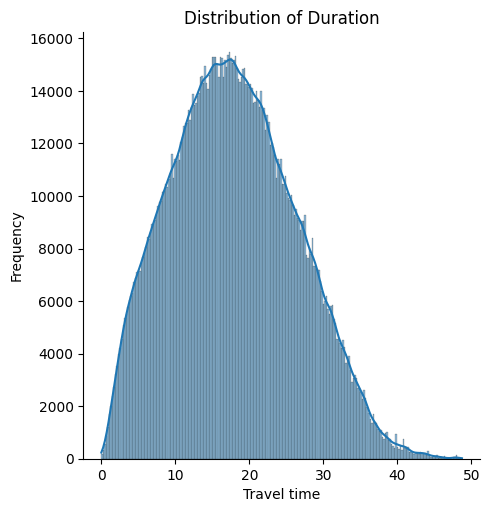

In [5]:
plt.title('Distribution of Duration')
plt.xlabel('Travel time')
plt.ylabel('Frequency')
plt.show()          

In [ ]:
# 3. distribution plot of population/duration
sns.scatterplot(x='Accessibility_standard', y='population', data=origin_dest_acc)

In [ ]:
plt.xlabel('Accessibility Score')
plt.ylabel('Population')

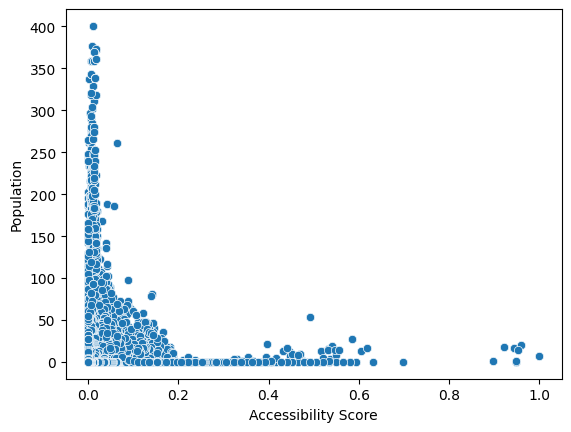

In [6]:
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=origin_dest_acc, x='Local_Validation')

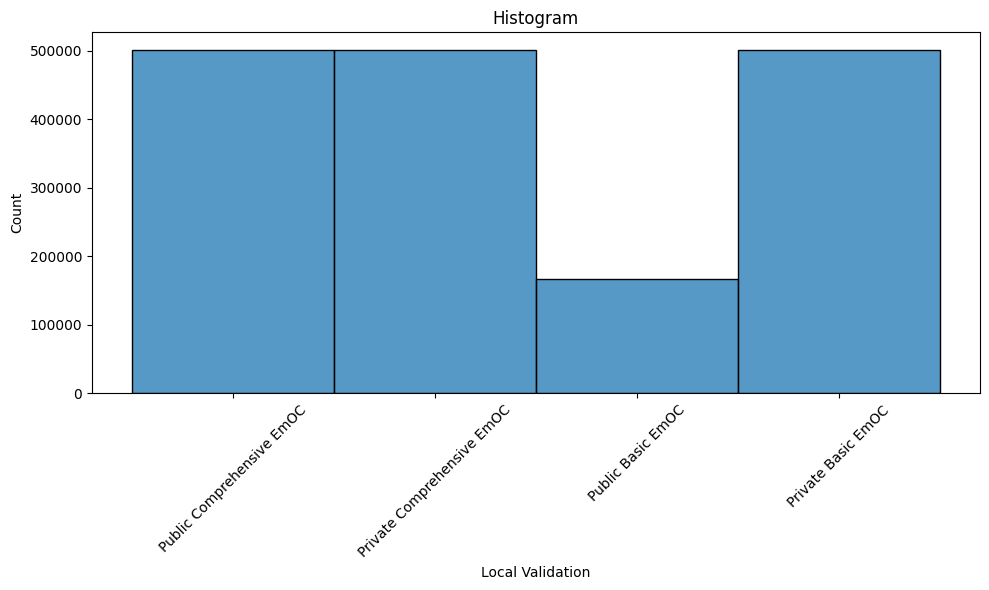

In [22]:
plt.title('Histogram')
plt.xlabel('Local Validation')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(20, 7))
sns.histplot(
    data=origin_dest_acc,
    x='facility_name',
    discrete=True,
    color='skyblue',
    edgecolor='black'
)

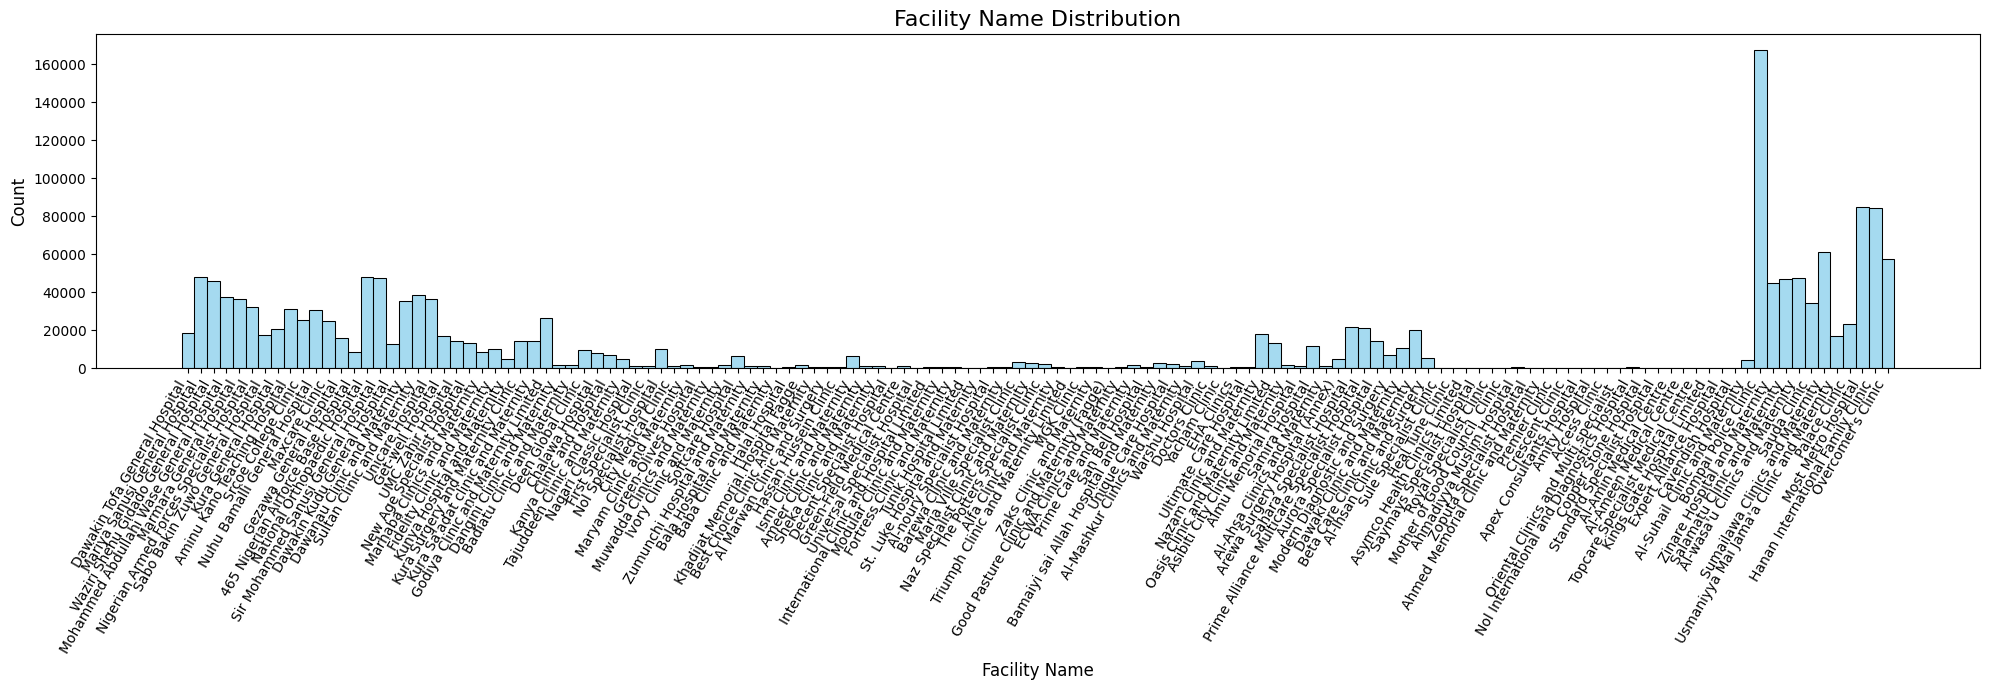

In [21]:
plt.title('Facility Name Distribution', fontsize=16)
plt.xlabel('Facility Name', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=60, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os
from matplotlib import gridspec

In [ ]:
data_folder = 'data_outputs/acc_score_3_closest_Emoc'

In [ ]:
file_names = [f for f in os.listdir(data_folder) if f.endswith('.gpkg')] 

In [ ]:
fig = plt.figure(figsize=(20, 15))
gs = gridspec.GridSpec(4, 5, figure=fig)

In [ ]:
y_labels = ['5min', '10min', '15min', '20min']
x_labels = [0.75, 0.5, 0.1, 0.05, 0.01]

In [ ]:
for i, file_name in enumerate(file_names):
    file_path = os.path.join(data_folder, file_name)
    gdf = gpd.read_file(file_path)

    match = re.search(r'd(\d+)', file_name)
    if match:
        d_value = int(match.group(1))
        y_position = 3 - (d_value // 5 - 1)

    match = re.search(r'w(\d+\.\d+)', file_name)
    if match:
        w_value = float(match.group(1))
        x_position = x_labels.index(w_value)

    ax = fig.add_subplot(gs[y_position, x_position])
    
    sns.scatterplot(x='Accessibility_standard', y='population', data=gdf, ax=ax)
    ax.set_xlabel('Accessibility Score')
    ax.set_ylabel('Population')

In [ ]:
plt.tight_layout()
output_image_path = 'data_outputs/output_image.png'
plt.savefig(output_image_path, bbox_inches='tight', dpi=300)

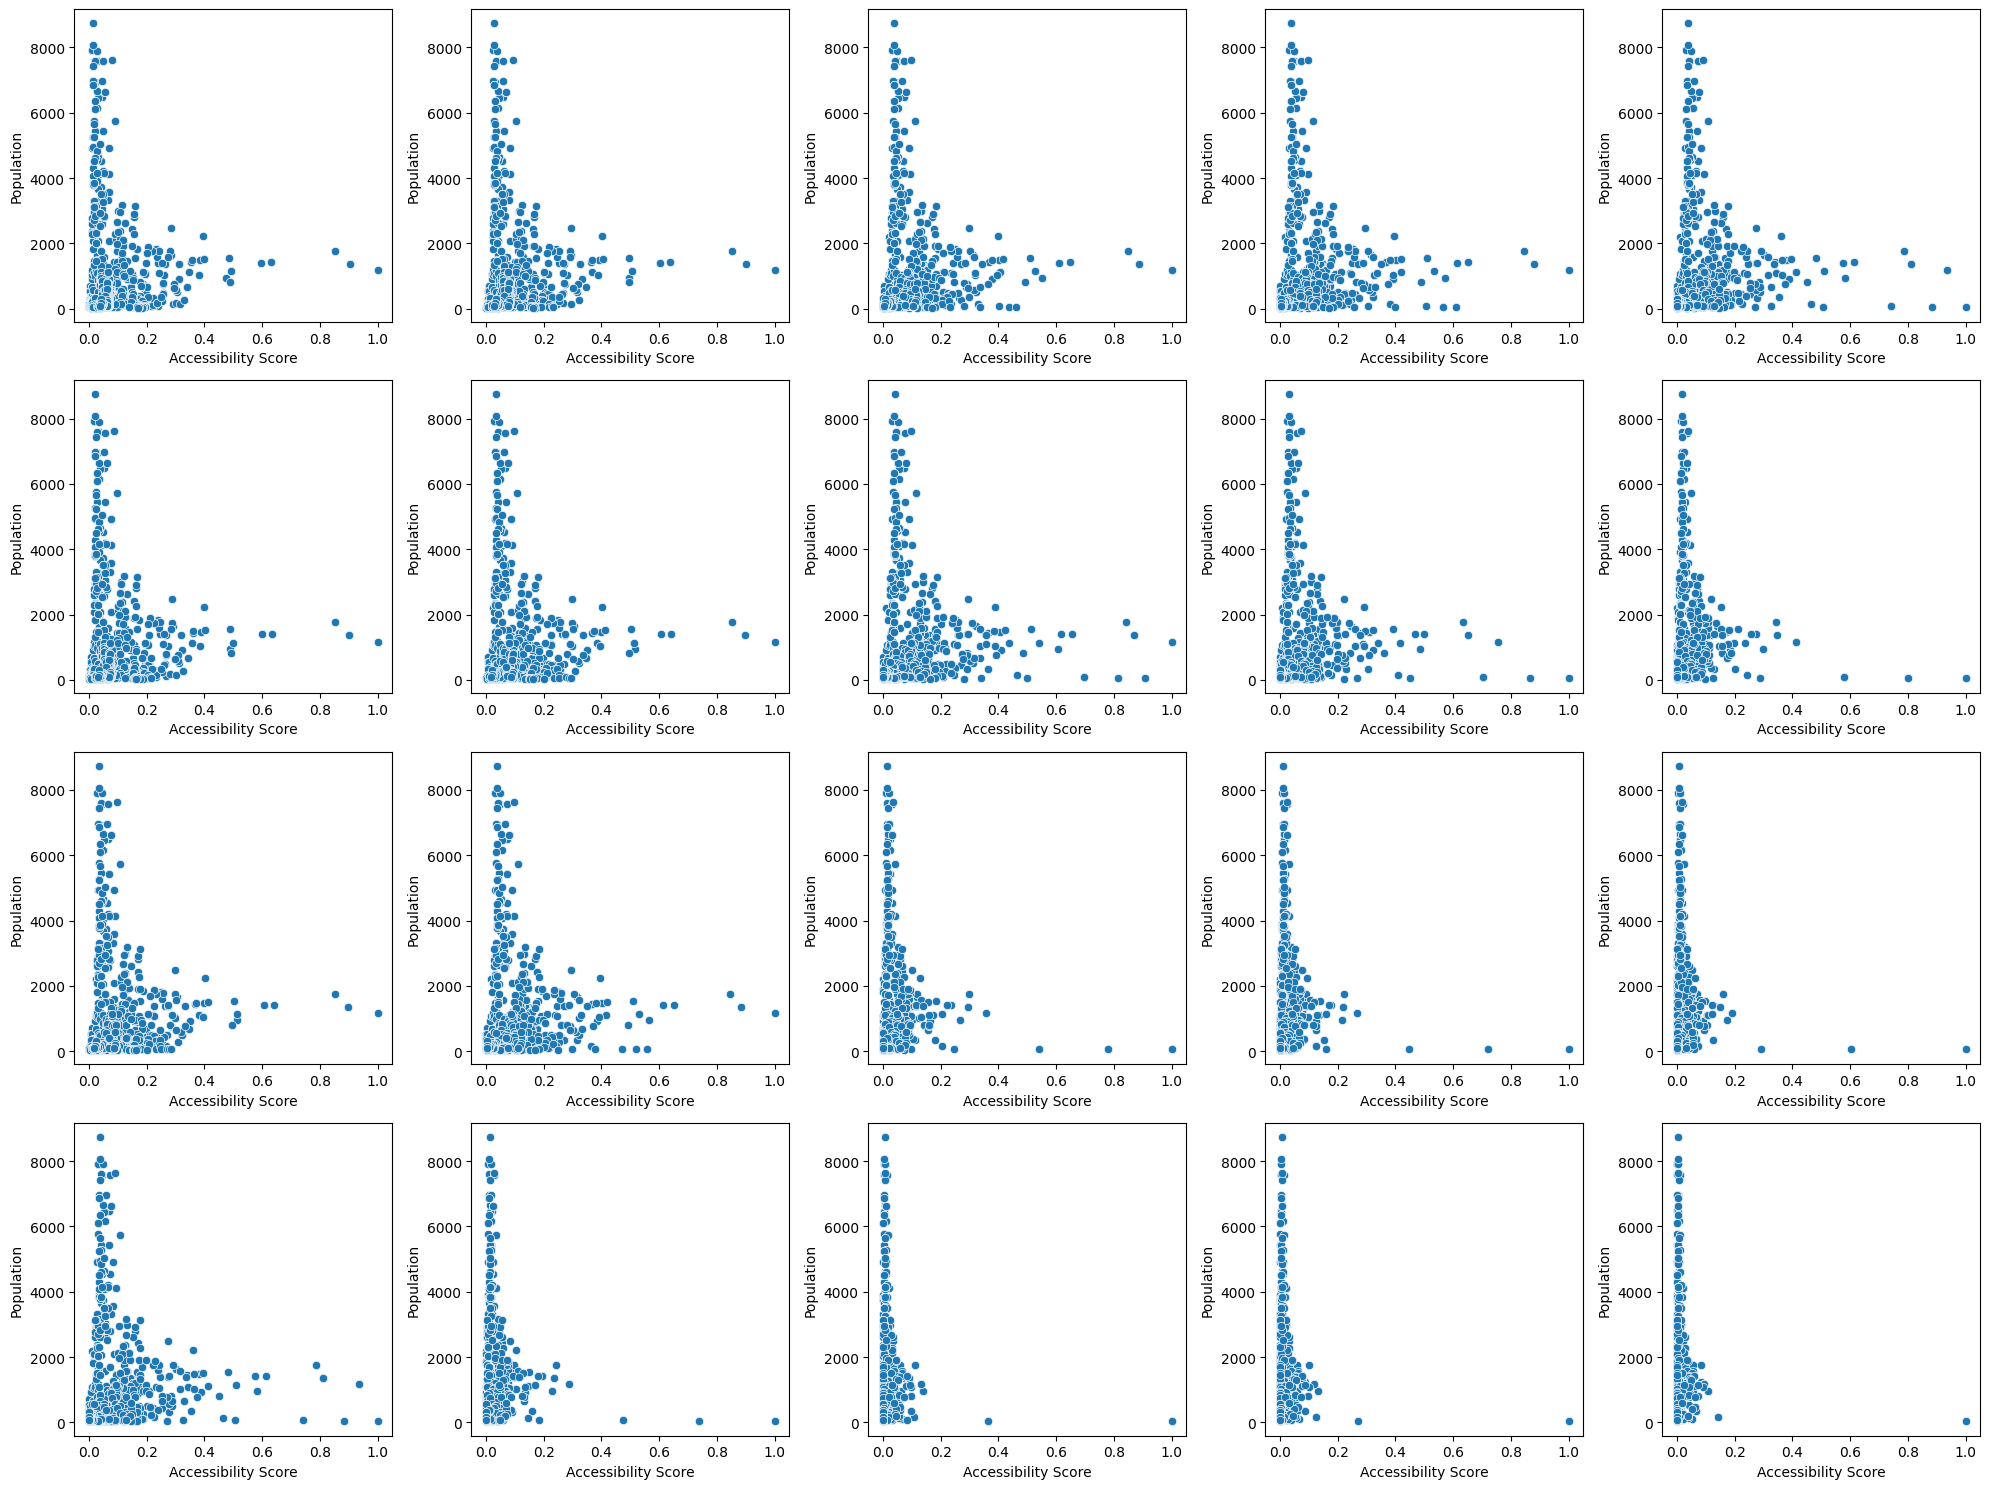

In [27]:
plt.show()

# 4. Grouping by grid ID to prepare the final output file
There is a need to update this part of the code

In [97]:
# Read the GeoPackage file (if starting from this section)
results_grid = gpd.read_file(data_outputs + 'acc_score_3_closet_Emoc_d10_w0.01_supply_weighted.gpkg')
results_grid = results_grid[['grid_id', 'origin_lon', 'origin_lat', 'origin_lon_min', 'origin_lat_min', 'origin_lon_max', 'origin_lat_max', 'Accessibility_standard', 'geometry']]

Group by multiple columns and calculate the mean for numeric columns
results_grid = results_grid.groupby(['grid_id', 'origin_lon', 'origin_lat', 'origin_lon_min', 'origin_lat_min', 'origin_lon_max', 'origin_lat_max', 'Accessibility_standard']).count().reset_index()

In [ ]:
results_grid = results_grid.drop_duplicates(['grid_id', 'origin_lon', 'origin_lat', 'origin_lon_min', 'origin_lat_min', 'origin_lon_max', 'origin_lat_max', 'Accessibility_standard', 'geometry'])

In [99]:
type(results_grid)

geopandas.geodataframe.GeoDataFrame

In [ ]:
results_grid

### Setting values for Low medium and High categories

We started by defining equal value division, and modified the thesholds to a value that is more legible and easier to interpret. Every model should have their own thresholds based on the data distribution of the three categories. 

Note: For Kano, we excluded grid cells with index values below 0.000001 that indicated very low population and a small number of buildings.  

In [ ]:
results_grid['result'] = -1
results_grid.loc[results_grid['Accessibility_standard'] > 0.000001, 'result'] = 2
results_grid.loc[results_grid['Accessibility_standard'] > 0.005, 'result'] = 1
results_grid.loc[results_grid['Accessibility_standard'] > 0.02, 'result'] = 0

### Setting values for focus areas

We defined the focus areas based on values for the different thresholds. We aim at participants helping us to confirm the selection of the city-specific thresholds.

In [ ]:
results_grid['focused'] = 0
# Focus areas between the Low category and the excluded cells due to low population or no buildings
results_grid.loc[(results_grid['Accessibility_standard'] > 0.000001) & (results_grid['Accessibility_standard'] < 0.0000015), 'focused'] = 1
# Focus areas between the Medium and High categories
results_grid.loc[(results_grid['Accessibility_standard'] > 0.003) & (results_grid['Accessibility_standard'] < 0.006), 'focused'] = 1
# Focus areas between the Low and Medium categories
results_grid.loc[(results_grid['Accessibility_standard'] > 0.019) & (results_grid['Accessibility_standard'] < 0.03), 'focused'] = 1

In [85]:
results_grid

,grid_id,origin_lon,origin_lat,origin_lon_min,origin_lat_min,origin_lon_max,origin_lat_max,Accessibility_standard
0,1,8.301005,12.122137,8.300491,12.121729,8.301519,12.122545,4.124253e-03
1,2,8.319272,12.072376,8.318758,12.071968,8.319786,12.072784,1.465780e-03
2,3,8.330126,12.110716,8.329612,12.110308,8.330640,12.111124,2.155933e-02
3,4,8.330079,12.108269,8.329565,12.107861,8.330593,12.108676,2.423898e-02
4,5,8.332575,12.027513,8.332061,12.027105,8.333088,12.027921,0.000000e+00
...,...,...,...,...,...,...,...,...
429256,154653,8.698358,11.854612,8.697845,11.854204,8.698872,11.855020,1.144123e-07
429257,154654,8.698342,11.853797,8.697829,11.853389,8.698856,11.854204,1.013907e-07
429258,154655,8.698326,11.852981,8.697813,11.852573,8.698840,11.853389,7.998461e-08
429536,154933,8.699370,11.854612,8.698856,11.854204,8.699883,11.855020,1.543766e-07


In [ ]:
results_grid = results_grid.loc[results_grid['result'] != -1]

In [ ]:
results_grid = results_grid.rename(columns={
    'origin_lon': 'longitude',
    'origin_lat': 'latitude',
    'origin_lon_min': 'lon_min',
    'origin_lat_min': 'lat_min',
    'origin_lon_max': 'lon_max',
    'origin_lat_max': 'lat_max'
})

In [115]:
results_grid

,grid_id,origin_lon,origin_lat,origin_lon_min,origin_lat_min,origin_lon_max,origin_lat_max,Accessibility_standard,geometry,focused,result
0,1,8.301005,12.122137,8.300491,12.121729,8.301519,12.122545,4.124253e-03,"POLYGON ((8.30051 12.12254, 8.30152 12.12254, ...",1,2
1,2,8.319272,12.072376,8.318758,12.071968,8.319786,12.072784,1.465780e-03,"POLYGON ((8.31877 12.07278, 8.31979 12.07278, ...",0,2
2,3,8.330126,12.110716,8.329612,12.110308,8.330640,12.111124,2.155933e-02,"POLYGON ((8.32963 12.11112, 8.33064 12.11112, ...",1,0
3,4,8.330079,12.108269,8.329565,12.107861,8.330593,12.108676,2.423898e-02,"POLYGON ((8.32958 12.10868, 8.33059 12.10868, ...",1,0
4,5,8.332575,12.027513,8.332061,12.027105,8.333088,12.027921,0.000000e+00,"POLYGON ((8.33208 12.02792, 8.33309 12.02792, ...",0,-1
...,...,...,...,...,...,...,...,...,...,...,...
429256,154653,8.698358,11.854612,8.697845,11.854204,8.698872,11.855020,1.144123e-07,"POLYGON ((8.69786 11.85502, 8.69887 11.85502, ...",0,-1
429257,154654,8.698342,11.853797,8.697829,11.853389,8.698856,11.854204,1.013907e-07,"POLYGON ((8.69784 11.8542, 8.69886 11.8542, 8....",0,-1
429258,154655,8.698326,11.852981,8.697813,11.852573,8.698840,11.853389,7.998461e-08,"POLYGON ((8.69783 11.85339, 8.69884 11.85339, ...",0,-1
429536,154933,8.699370,11.854612,8.698856,11.854204,8.699883,11.855020,1.543766e-07,"POLYGON ((8.69887 11.85502, 8.69988 11.85502, ...",0,-1


In [119]:
# Save the results to a new GeoPackage file
output_gpkg_path = data_outputs + 'emergency-maternal-care-deprivation-access.gpkg'
results_grid.to_file(output_gpkg_path, layer='emergency-maternal-care-deprivation-access', driver='GPKG')

In [125]:
# Save the results to a CSV file in the format required by the IDEAMAPS data ecosystem
results_table = results_grid.drop(columns=['Accessibility_standard', 'grid_id', 'geometry'])
results_table.to_csv(model_outputs + 'model-output.csv', index=False)

In [117]:
results_table

,origin_lon,origin_lat,origin_lon_min,origin_lat_min,origin_lon_max,origin_lat_max,geometry,focused,result
0,8.301005,12.122137,8.300491,12.121729,8.301519,12.122545,"POLYGON ((8.30051 12.12254, 8.30152 12.12254, ...",1,2
1,8.319272,12.072376,8.318758,12.071968,8.319786,12.072784,"POLYGON ((8.31877 12.07278, 8.31979 12.07278, ...",0,2
2,8.330126,12.110716,8.329612,12.110308,8.330640,12.111124,"POLYGON ((8.32963 12.11112, 8.33064 12.11112, ...",1,0
3,8.330079,12.108269,8.329565,12.107861,8.330593,12.108676,"POLYGON ((8.32958 12.10868, 8.33059 12.10868, ...",1,0
5,8.397532,12.091138,8.397019,12.090730,8.398046,12.091546,"POLYGON ((8.39703 12.09155, 8.39805 12.09155, ...",0,1
...,...,...,...,...,...,...,...,...,...
423226,8.676033,11.850535,8.675520,11.850127,8.676547,11.850943,"POLYGON ((8.67554 11.85094, 8.67655 11.85094, ...",1,2
423227,8.676017,11.849719,8.675504,11.849312,8.676531,11.850127,"POLYGON ((8.67552 11.85013, 8.67653 11.85013, ...",0,2
423228,8.676001,11.848904,8.675488,11.848496,8.676515,11.849312,"POLYGON ((8.6755 11.84931, 8.67651 11.84931, 8...",1,2
423500,8.677044,11.850535,8.676531,11.850127,8.677558,11.850943,"POLYGON ((8.67655 11.85094, 8.67756 11.85094, ...",1,2
